In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def fourier(time,array):

        fft = np.fft.fft(array)

        Npts = len(array)
        spacing_array = time[::-1][:-1][::-1] - time[:-1]

        if np.mean(spacing_array) - spacing_array[0] > 1.e-16:
                print "time axis not equally separated. cannot compute fft"
                sys.exit()
        spacing = spacing_array[0]

        freq = np.fft.fftfreq(Npts, spacing)
        freq = freq*360.*3600. # convert frequency from cycles/years to arcsecs/years

        return freq,fft

def get_ccv(e,i,pomega,Omega):

        p_e = 2.0*(1.0 - np.sqrt(1.0 - e*e))
        p_i = 4.0*np.sqrt(1.0 - e*e)*np.sin(i/2.0)*np.sin(i/2.0)

        z = np.sqrt(p_e)*np.exp(pomega*1j)
        zeta = np.sqrt(p_i)*np.exp(Omega*1j)

        return z, zeta

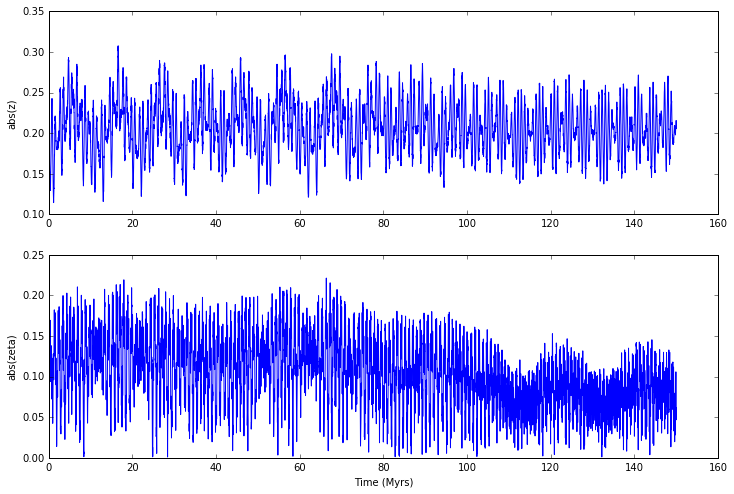

In [3]:
filename = "mercury_orbparams.txt"
data = np.loadtxt(filename)
time = data[:,0]
idx = np.where(time<150.e6)
time = time[idx]
ecc = data[:,1][idx]
inc = data[:,2][idx]
pomega = data[:,3][idx]
Omega = data[:,4][idx]
z,zeta = get_ccv(ecc,inc,pomega,Omega)

ecc_mercury = np.absolute(z)
inc_mercury = np.absolute(zeta)

# testing the get_ccv routine to see if we can get the original ecc, inc from z and zeta
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.ylabel("abs(z)")
plt.plot(time/1.e6,ecc_mercury)
plt.subplot(2,1,2)
plt.xlabel("Time (Myrs)")
plt.ylabel("abs(zeta)")
plt.plot(time/1.e6,inc_mercury)

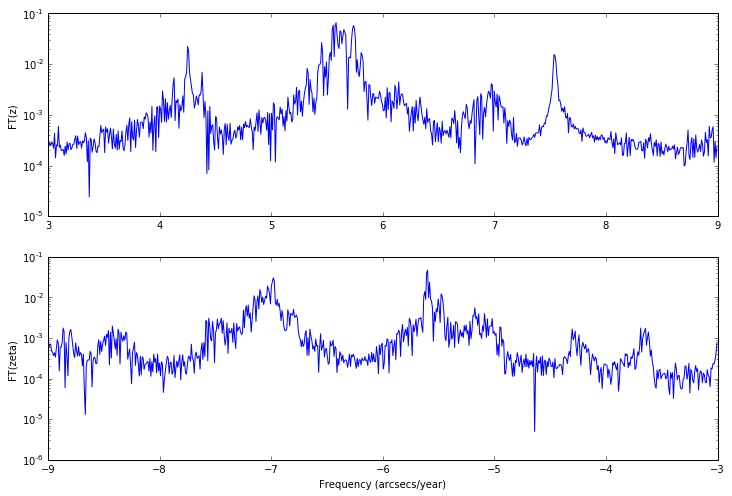

In [4]:
# testing the fourier transform routine, comparing it to fig. 15 from Lithwick & Wu, 2011
z_freq, z_fft = fourier(time,z)
zeta_freq, zeta_fft = fourier(time,zeta)

nsamples = len(z)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.ylabel("FT(z)")
idx = np.logical_and(z_freq<9,z_freq>3)
plt.semilogy(sorted(z_freq[idx]),[b for (a,b) in sorted(zip(z_freq[idx],np.absolute(z_fft[idx])/nsamples))])
plt.subplot(2,1,2)
plt.xlabel("Frequency (arcsecs/year)")
plt.ylabel("FT(zeta)")
idx = np.logical_and(zeta_freq<-3,zeta_freq>-9)
plt.semilogy(sorted(zeta_freq[idx]),[b for (a,b) in sorted(zip(zeta_freq[idx],np.absolute(zeta_fft[idx])/nsamples))])

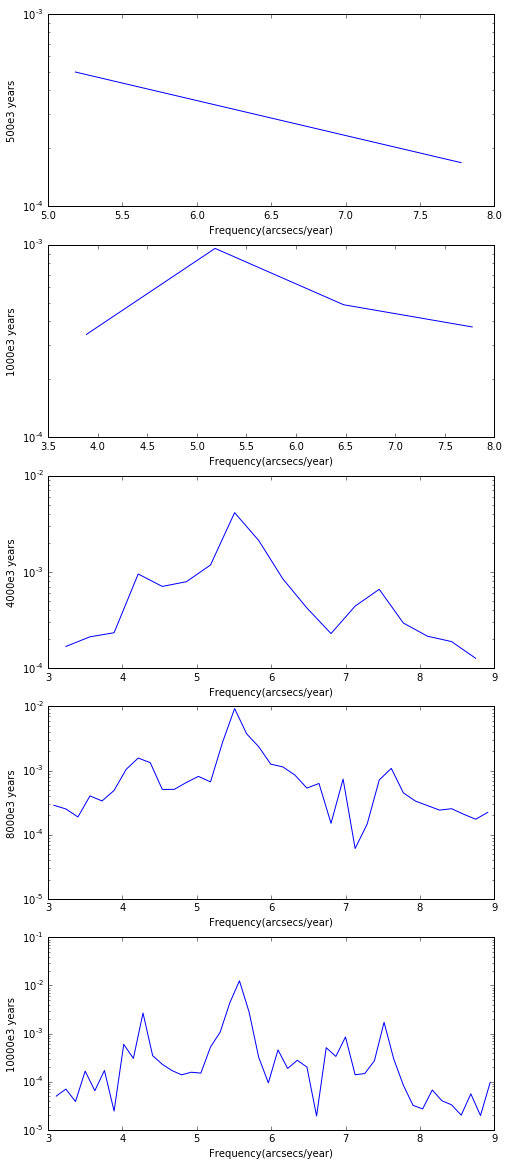

In [5]:
# testing for appropriate window size
window_array = [500,1000,4000,8000,10000]
plt.figure(figsize=(8,20))
for i,x in enumerate(window_array):
    plt.subplot(len(window_array),1,i+1)
    freq,fft = fourier(time[0:x],z[0:x])
    idx = np.logical_and(freq<9,freq>3)
    plt.xlabel("Frequency(arcsecs/year)")
    plt.ylabel(str(x)+"e3 years")
    plt.semilogy(sorted(freq[idx]),[b for (a,b) in sorted(zip(freq[idx],np.absolute(fft[idx])/nsamples))])


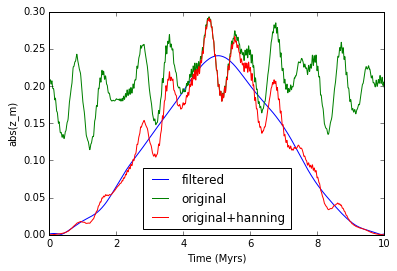

In [6]:
# comparison of original signal with original signal after the Hanning window and the filtered signal
# this is where I save the zeroth frequency from the fourier transform 

length = 10000 # length of Hanning window, 5.e5 years
window = np.hanning(length)
N = len(z)

time_fourier = time[0:length] # time for the fourier transform
array = z[0:length]

z_hanning = window*array
z_freq, z_fft = fourier(time_fourier,z_hanning) # returns frequency and FT

z_zero = z_fft[np.where(z_freq == 0)]
# set FT(f) outside of frequency window to 0
idx = np.where(z_freq<4.5)
z_fft[idx] = 0
idx = np.where(z_freq>6.5)
z_fft[idx] = 0
z_fft[0] = z_zero[0] # reset the zeroth frequency to its value (not to filter it)
z_ifft = np.fft.ifft(z_fft) # return to time domain

plt.figure()
plt.xlabel("Time (Myrs)")
plt.ylabel("abs(z_m)")
plt.plot(time_fourier/1.e6,np.absolute(z_ifft),label="filtered")
plt.plot(time_fourier/1.e6,np.absolute(z[0:length]),label="original")
plt.plot(time_fourier/1.e6,np.absolute(z_hanning),label="original+hanning")
plt.legend(loc="best")
   

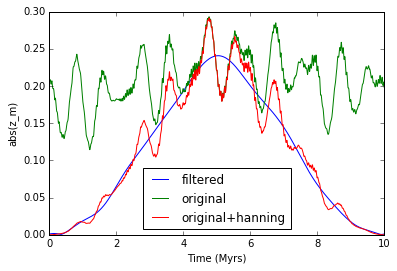

In [7]:
# comparison of original signal with original signal after the Hanning window and the filtered signal
# this is where I save the average of the signal and use that as the zeroth frequency

length = 10000 # length of Hanning window, 5.e5 years
window = np.hanning(length)
N = len(z)

time_fourier = time[0:length] # time for the fourier transform
array = z[0:length]
zero_abs = np.mean(np.absolute(array)) #mean of absolute value (eccentricty)
zero_angle = np.mean(np.angle(array)) #mean of angle value (pomega)
z_zero = zero_abs*np.exp(1j*zero_angle) #mean which the zeroth frequency will be set to

z_hanning = window*array
z_freq, z_fft = fourier(time_fourier,z_hanning) # returns frequency and FT

# set FT(f) outside of frequency window to 0
idx = np.where(z_freq<4.5)
z_fft[idx] = 0
idx = np.where(z_freq>6.5)
z_fft[idx] = 0
z_fft[0] = z_zero # reset the zeroth frequency to its value (not to filter it)
z_ifft = np.fft.ifft(z_fft) # return to time domain

plt.figure()
plt.xlabel("Time (Myrs)")
plt.ylabel("abs(z_m)")
plt.plot(time_fourier/1.e6,np.absolute(z_ifft),label="filtered")
plt.plot(time_fourier/1.e6,np.absolute(z[0:length]),label="original")
plt.plot(time_fourier/1.e6,np.absolute(z_hanning),label="original+hanning")
plt.legend(loc="best")